# 🐾 Complete Animal Footprint Classifier Pipeline

**This notebook contains the full pipeline:**
1. Setup & Configuration
2. Data Exploration
3. Data Loading & Augmentation
4. Model Building
5. Training
6. Evaluation & Results

**Dynamic:** Automatically detects all animal classes from folders!

---
## 1. Setup & Configuration

In [46]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


In [47]:
# ============================================
# CONFIGURATION - Modify these as needed
# ============================================

# Data paths
DATA_DIR = "C:/Users/ayoub/Desktop/DL_PROJECT/PROJECT/Footprint_Classification_Project/data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VALID_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Model settings
IMG_SIZE = (224, 224)  # Image dimensions
BATCH_SIZE = 16        # Images per batch
EPOCHS = 300            # Maximum training epochs

# Output paths
MODEL_DIR = "C:/Users/ayoub/Desktop/DL_PROJECT/PROJECT/Footprint_Classification_Project/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# DYNAMIC: Auto-detect number of classes
CLASS_NAMES = sorted(os.listdir(TRAIN_DIR))
NUM_CLASSES = len(CLASS_NAMES)

print(f"\n{'='*50}")
print(f"CONFIGURATION")
print(f"{'='*50}")
print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")
print(f"\nDetected {NUM_CLASSES} classes: {CLASS_NAMES}")


CONFIGURATION
Image size: (224, 224)
Batch size: 16
Max epochs: 300

Detected 3 classes: ['domestic_cat', 'domestic_dog', 'european_badger']


---
## 2. Data Exploration

In [48]:
def count_images(directory):
    """Count images in each class folder."""
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

# Count images in each split
train_counts = count_images(TRAIN_DIR)
valid_counts = count_images(VALID_DIR)
test_counts = count_images(TEST_DIR)

print(f"{'='*50}")
print(f"DATA SUMMARY")
print(f"{'='*50}")
print(f"\n{'Class':<20} {'Train':>8} {'Valid':>8} {'Test':>8}")
print("-" * 50)
for class_name in CLASS_NAMES:
    train = train_counts.get(class_name, 0)
    valid = valid_counts.get(class_name, 0)
    test = test_counts.get(class_name, 0)
    print(f"{class_name:<20} {train:>8} {valid:>8} {test:>8}")
print("-" * 50)
print(f"{'TOTAL':<20} {sum(train_counts.values()):>8} {sum(valid_counts.values()):>8} {sum(test_counts.values()):>8}")

DATA SUMMARY

Class                   Train    Valid     Test
--------------------------------------------------
domestic_cat               65       17       35
domestic_dog               34        5        9
european_badger            64        9       17
--------------------------------------------------
TOTAL                     163       31       61


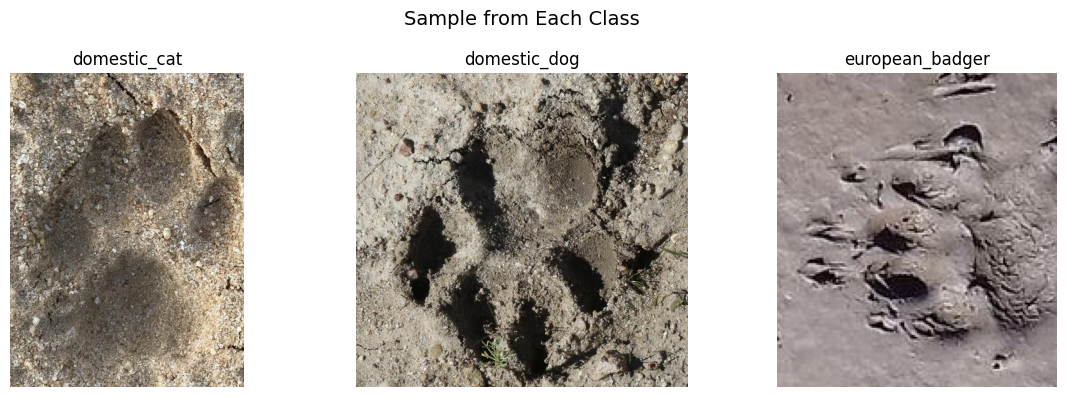

In [49]:
# Visualize sample images from each class
n_classes = len(CLASS_NAMES)
fig, axes = plt.subplots(1, n_classes, figsize=(4 * n_classes, 4))
if n_classes == 1:
    axes = [axes]

for i, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(TRAIN_DIR, class_name)
    image_name = os.listdir(class_path)[0]
    image_path = os.path.join(class_path, image_name)
    
    img = plt.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(class_name, fontsize=12)
    axes[i].axis('off')

plt.suptitle("Sample from Each Class", fontsize=14)
plt.tight_layout()
plt.show()

---
## 3. Data Loading & Augmentation

In [50]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2]
)

# No augmentation for validation/test
valid_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = valid_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nClass mapping: {train_generator.class_indices}")

Found 163 images belonging to 3 classes.
Found 31 images belonging to 3 classes.
Found 61 images belonging to 3 classes.

Class mapping: {'domestic_cat': 0, 'domestic_dog': 1, 'european_badger': 2}


---
## 4. Build the CNN Model

In [51]:
def build_cnn(input_shape, num_classes):
    """
    Build a simple CNN for footprint classification.
    
    Args:
        input_shape: Tuple (height, width, channels)
        num_classes: Number of output classes
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Classification head
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build model
model = build_cnn(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=NUM_CLASSES
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

---
## 5. Training

In [52]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        os.path.join(MODEL_DIR, 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Starting training...")
print("="*50)

Starting training...


In [53]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=callbacks
)

print("="*50)
print("Training complete!")

Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.3420 - loss: 1.7934
Epoch 1: val_accuracy improved from None to 0.32258, saving model to C:/Users/ayoub/Desktop/DL_PROJECT/PROJECT/Footprint_Classification_Project/models\best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3742 - loss: 1.4811 - val_accuracy: 0.3226 - val_loss: 1.0986
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.4196 - loss: 1.0968
Epoch 2: val_accuracy improved from 0.32258 to 0.54839, saving model to C:/Users/ayoub/Desktop/DL_PROJECT/PROJECT/Footprint_Classification_Project/models\best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 959ms/step - accuracy: 0.4233 - loss: 1.0957 - val_accuracy: 0.5484 - val_loss: 1.0913
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.4527 - loss: 1.0935
Epoch 3: val_accuracy did not improve from 0.54839
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 855ms/step - accuracy: 0.3988 - loss: 1.0946 - val_accuracy: 0.5484 - val_loss: 1.087

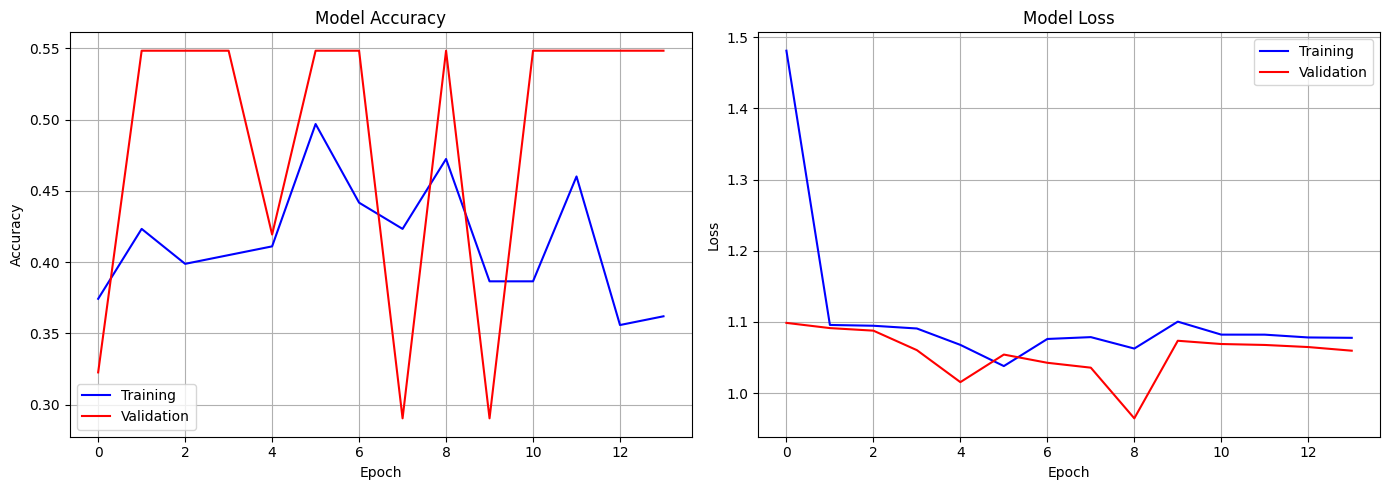

In [54]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], 'b-', label='Training')
ax1.plot(history.history['val_accuracy'], 'r-', label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], 'b-', label='Training')
ax2.plot(history.history['val_loss'], 'r-', label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'training_history.png'), dpi=150)
plt.show()

In [55]:
# Save final model
model.save(os.path.join(MODEL_DIR, 'footprint_classifier.keras'))
print(f"Model saved to {MODEL_DIR}/footprint_classifier.keras")

Model saved to C:/Users/ayoub/Desktop/DL_PROJECT/PROJECT/Footprint_Classification_Project/models/footprint_classifier.keras


---
## 6. Evaluation & Results

In [56]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"\n{'='*50}")
print(f"TEST RESULTS")
print(f"{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"{'='*50}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.5738 - loss: 0.9682

TEST RESULTS
Test Loss: 0.9682
Test Accuracy: 57.38%


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step


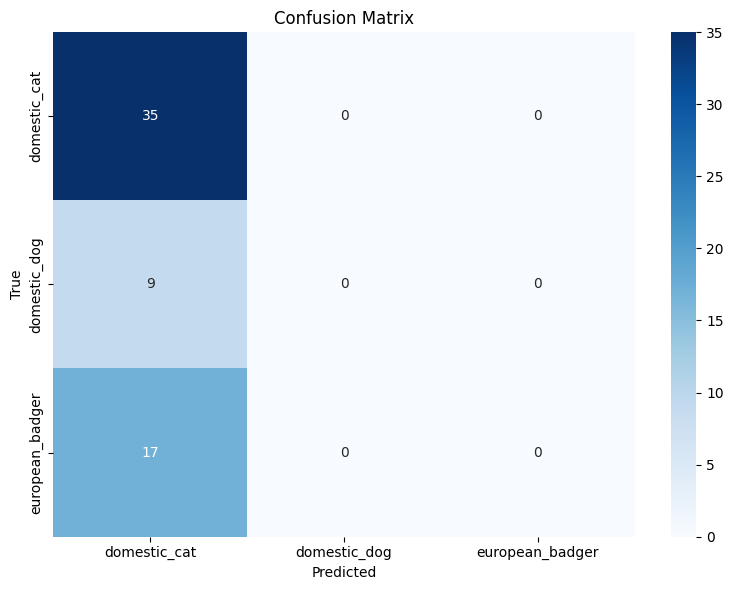

In [57]:
# Get predictions for confusion matrix
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'confusion_matrix.png'), dpi=150)
plt.show()

In [58]:
# Classification report
print("\nCLASSIFICATION REPORT")
print("="*60)
print(classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES))


CLASSIFICATION REPORT
                 precision    recall  f1-score   support

   domestic_cat       0.57      1.00      0.73        35
   domestic_dog       0.00      0.00      0.00         9
european_badger       0.00      0.00      0.00        17

       accuracy                           0.57        61
      macro avg       0.19      0.33      0.24        61
   weighted avg       0.33      0.57      0.42        61



c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\DLV\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\DLV\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\DLV\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

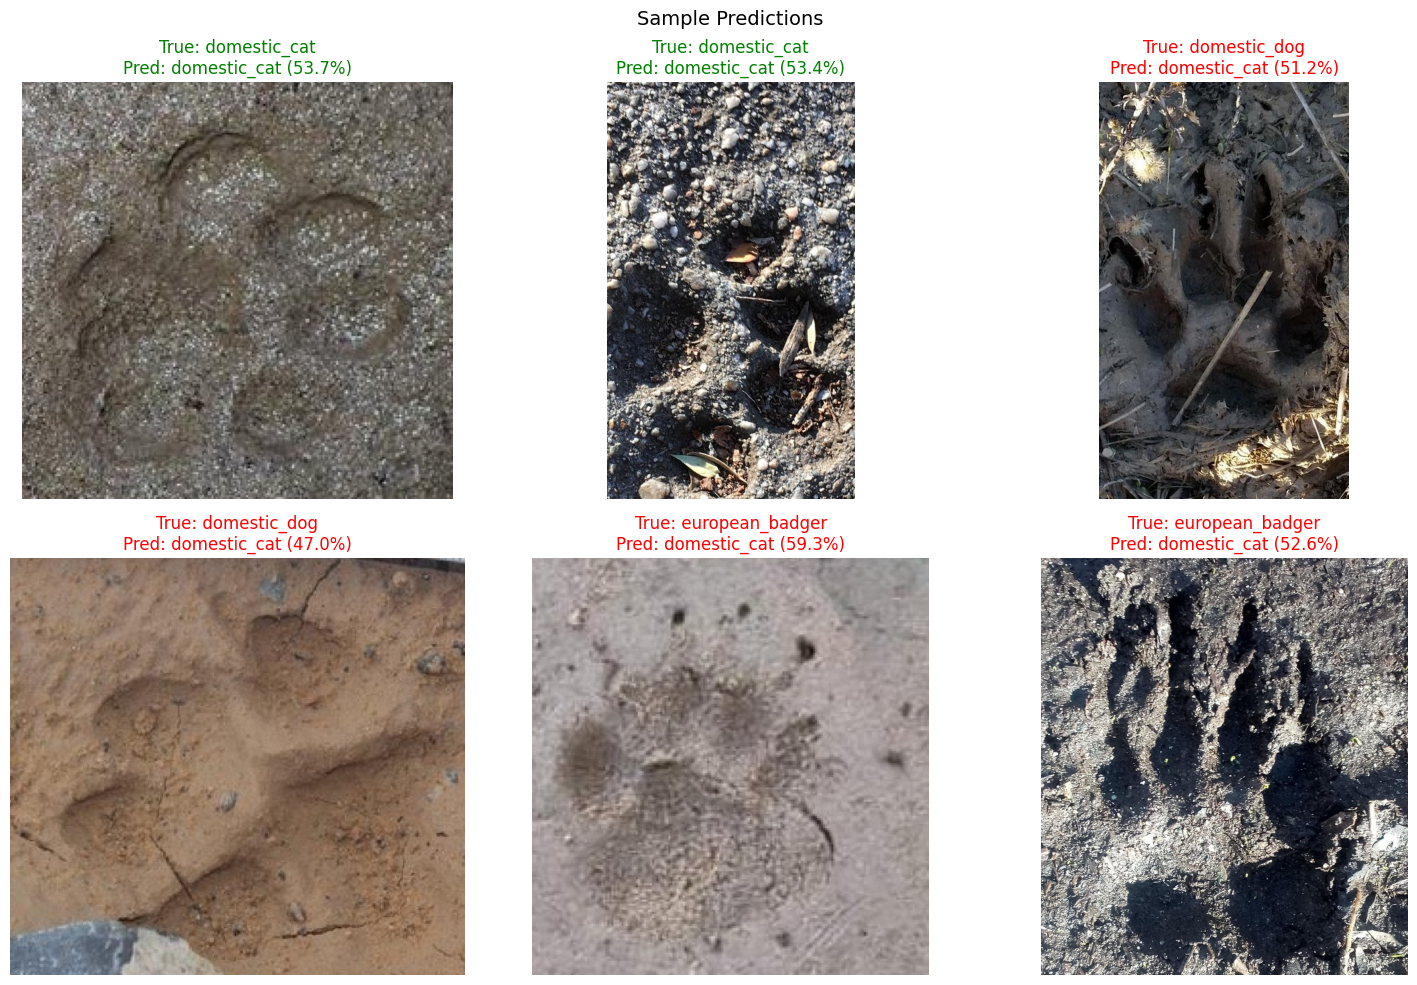

In [59]:
# Sample predictions visualization
def predict_single(image_path):
    """Predict class for a single image."""
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    preds = model.predict(img_array, verbose=0)
    return CLASS_NAMES[np.argmax(preds[0])], np.max(preds[0])

# Show predictions on sample images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

samples = []
for cls in CLASS_NAMES[:3]:
    cls_path = os.path.join(TEST_DIR, cls)
    for img in os.listdir(cls_path)[:2]:
        samples.append((os.path.join(cls_path, img), cls))

for i, (path, true_label) in enumerate(samples[:6]):
    pred, conf = predict_single(path)
    img = plt.imread(path)
    axes[i].imshow(img)
    color = 'green' if pred == true_label else 'red'
    axes[i].set_title(f"True: {true_label}\nPred: {pred} ({conf:.1%})", color=color)
    axes[i].axis('off')

plt.suptitle('Sample Predictions', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'sample_predictions.png'), dpi=150)
plt.show()

---
## 📊 Final Summary

In [60]:
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"\n📊 Classes: {NUM_CLASSES}")
print(f"   {CLASS_NAMES}")
print(f"\n🖼️ Data:")
print(f"   Training: {train_generator.samples} images")
print(f"   Validation: {valid_generator.samples} images")
print(f"   Test: {test_generator.samples} images")
print(f"\n🎯 Test Accuracy: {test_accuracy:.2%}")
print(f"\n💾 Saved files:")
print(f"   - {MODEL_DIR}/best_model.keras")
print(f"   - {MODEL_DIR}/footprint_classifier.keras")
print(f"   - {MODEL_DIR}/training_history.png")
print(f"   - {MODEL_DIR}/confusion_matrix.png")
print(f"   - {MODEL_DIR}/sample_predictions.png")
print("="*60)


FINAL SUMMARY

📊 Classes: 3
   ['domestic_cat', 'domestic_dog', 'european_badger']

🖼️ Data:
   Training: 163 images
   Validation: 31 images
   Test: 61 images

🎯 Test Accuracy: 57.38%

💾 Saved files:
   - C:/Users/ayoub/Desktop/DL_PROJECT/PROJECT/Footprint_Classification_Project/models/best_model.keras
   - C:/Users/ayoub/Desktop/DL_PROJECT/PROJECT/Footprint_Classification_Project/models/footprint_classifier.keras
   - C:/Users/ayoub/Desktop/DL_PROJECT/PROJECT/Footprint_Classification_Project/models/training_history.png
   - C:/Users/ayoub/Desktop/DL_PROJECT/PROJECT/Footprint_Classification_Project/models/confusion_matrix.png
   - C:/Users/ayoub/Desktop/DL_PROJECT/PROJECT/Footprint_Classification_Project/models/sample_predictions.png


---
## ✅ Pipeline Complete!

**To add more animals:**
1. Add new folders to `data/train/`, `data/valid/`, and `data/test/`
2. Re-run this notebook - it will automatically detect new classes!

**Model architecture:**
```
Input → Conv2D(32) → MaxPool → Conv2D(64) → MaxPool → Conv2D(128) → MaxPool → Dense(128) → Dropout → Dense(N)
```
Where N = number of animal classes (auto-detected)